## Runge-Kutta Method
- Implicit & Explicit iterative methods
- Similar concept to Euler's method, except modified to higher accuracy by using more terms

Let the initial value problem be:

$\frac{dy}{dx} = f(t,y)$ where $y(t_0) = y_0$

#### The procedure for Runge-Kutta 4 is as follows:

Pick a step size $h>0$ and define:

$y_{n+1} = y_n + \frac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)$ 

$t_{n+1} = t_n + h$

where

$k_1 = f(t_n, y_n)$,

$k_2 = f(t_n + \frac{h}{2}, y_n + h\frac{k_1}{2})$

$k_3 = f(t_n + \frac{h}{2}, y_n + h\frac{k_2}{2})$

$k_4 = f(t_n + h, y_n + hk_3)$

The $k_1, k_2, k_3, k_4$ values can be interpreted as:

1. The slope at the start, determined using Euler's method

2. The slope at the midpoint, found with slope $k_1$

3. The stope at the midpoint again, this time found with slope $k_2$

4. The slope at the endpoint, found with $k_3$

### Bicycle Model that we need to solve:
- Let $A$ be the natural system response matrix (2x2)
- Let $B$ be the control matrix
- We can formulate the overall state change matrix as $Ay + B\delta$

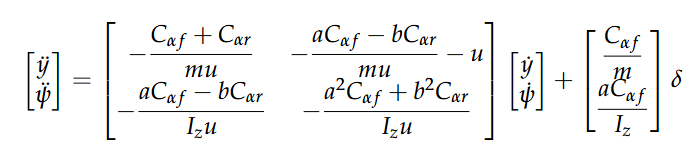

#### The Parameters we have are:

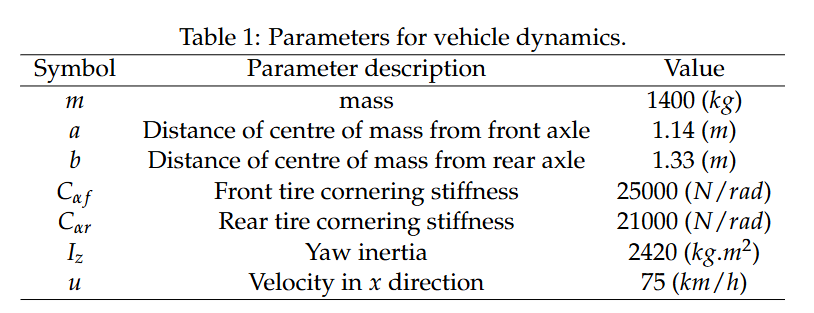

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [13]:
class BicycleSolver:
    def __init__(self, m, a, b, C_alpha_f, C_alpha_r, I_z, u):
        self.A = np.array(
            [[-1 * (C_alpha_f + C_alpha_r) / (m * u), (-1 * (a * C_alpha_f - b * C_alpha_r) / (m * u)) - u],
            [-1 * (a * C_alpha_f - b * C_alpha_r) / (I_z * u), -1 * (a**2 * C_alpha_f + b**2 * C_alpha_r) / (I_z * u)]]
        )

        self.B = np.array(
            [[C_alpha_f / m],
            [a*C_alpha_f / I_z]]
        )
    
    def solve(self, iterator, func, init_vector: np.ndarray, init_t, max_iter: int, step_size: float):
        """
        Generalized iterative solver that solves Y' = func using the specified iteration method.
        """
        y = init_vector.copy()
        res = []
        t = init_t
        for i in range(max_iter):
            y = iterator(func, y, t, step_size)
            t += step_size
            res.append(y)
        
        return y, res
    
    @staticmethod
    def eulers_method(func, y_curr: np.ndarray, t, step_size: float) -> np.ndarray:
        """
        Euler's Method for n-dimensional systems.
        
        Args:
            func: F(Y, t). (n, 1) output shape
            y_curr: Y_i. (n, 1) shaped
            step_size: delta t. Scalar

        Returns:
            y_next: Y_i+1. (n, 1) shaped
        """
        y_next = y_curr + step_size * func(y_curr, t)

        return y_next

    @staticmethod
    def rk4(func, y_curr: np.ndarray, t, step_size: float) -> np.ndarray:
        k1: np.ndarray = func(y_curr, t)

        v2: np.ndarray = y_curr + step_size / 2 * k1
        k2: np.ndarray = func(v2, t + step_size / 2)

        v3: np.ndarray = y_curr + step_size / 2 * k2
        k3: np.ndarray = func(v3, t + step_size / 2)

        v4: np.ndarray = y_curr + step_size * k3
        k4: np.ndarray = func(v4, t + step_size)

        return y_curr + step_size / 6 * (k1 + 2*k2 + 2*k3 + k4)
    
    @staticmethod
    def bicycle_model(A, B, y, delta) ->np.ndarray:
        return np.matmul(A, y) + B*delta
    
    @staticmethod
    def target(t):
        """
        Helper Function to test solver. Taken from the project manual, this computes the solution for time t
        using init [0,0] and table parameters.
        """
        return np.array(
            [[-13.0964*np.e**(-1 * 1.9745 * t) + 24.468*np.e**(-1*0.9839*t) - 11.3720],
            [-0.2496*np.e**(-1 * 1.9745 * t) - 0.69262*np.e**(-1*0.9839*t) + 0.9457]]
        )
    
    def visualize_results(self, histories, labels, init_t, t_final, max_iter, title=""):
        plt.close('all')
        plt.figure()
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[0] for val in hist], label=labels[i])

        # Y accel
        plt.xlabel('t')
        plt.ylabel("y accel")
        plt.legend()
        plt.grid()
        plt.title(title)
        plt.show()

        plt.figure()

        # Yaw Rate
        for i, hist in enumerate(histories):
            t_values = np.linspace(init_t, t_final, max_iter)
            plt.plot(t_values, [val[1] for val in hist], label=labels[i])

        plt.xlabel('t')
        plt.ylabel("Yaw Rate")
        plt.legend()
        plt.grid()
        plt.title(title)
        plt.show()
    
    def plot_ground_coordinates(self, histories):
        # TODO: Figure out how to do this
        # Looks like its integrating the X*, Y* and state vectors over time tho
        # Pretty annoying
        pass

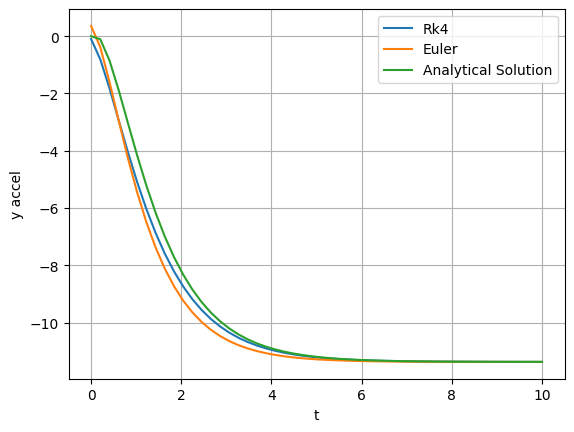

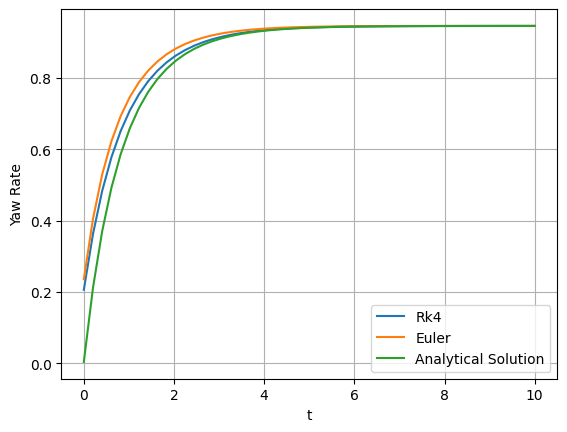

In [14]:
### Task A
def const_delta(t):
    return 0.1

init_vector = np.array([[0],[0]])
t_final = 10
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

solver = BicycleSolver(
    m = 1400,
    a = 1.14,
    b = 1.33,
    C_alpha_f = 25000,
    C_alpha_r = 21000,
    I_z = 2420,
    u = 75 * 1000 / 3600
)

def task_a_model(y, t) -> np.ndarray:
    return solver.bicycle_model(solver.A, solver.B, y, const_delta(t))

res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)
res_2, hist_2 = solver.solve(solver.eulers_method, task_a_model, init_vector, init_t, max_iter, step_size)
target_hist = [solver.target(t) for t in np.linspace(init_t, t_final, max_iter)]

solver.visualize_results([hist, hist_2, target_hist], ["Rk4", "Euler", "Analytical Solution"], init_t, t_final, max_iter)

Looks like the bicycle solver agrees with the given analytical solution :)

We still need to do grid independence check to verify that it's stable 

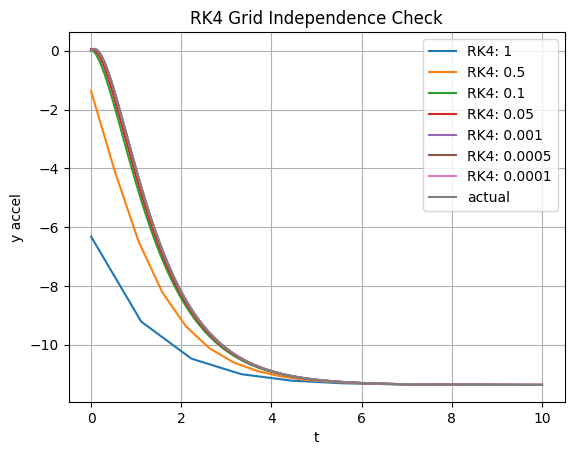

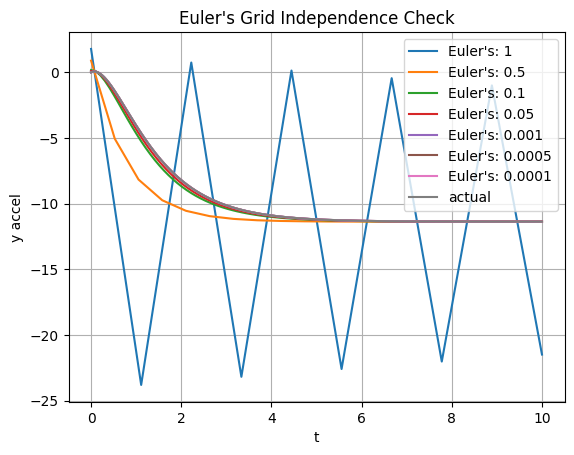

In [15]:
# Task A Q2
# Grid Independence Check
grid_values = [1, 0.5, 0.1, 0.05, 0.001, 0.0005, 0.0001]
init_vector = np.array([[0],[0]])
t_final = 10
init_t = 0

euler_results = []
rk4_results = []

solver = BicycleSolver(
    m = 1400,
    a = 1.14,
    b = 1.33,
    C_alpha_f = 25000,
    C_alpha_r = 21000,
    I_z = 2420,
    u = 75 * 1000 / 3600
)

for name, iterator in [("RK4", solver.rk4), ("Euler's", solver.eulers_method)]:
    for step_size in grid_values:
        max_iteration = int(t_final / step_size)
        _, hist_rk4 = solver.solve(iterator, task_a_model, init_vector, 0, max_iteration, step_size)

        t_values = np.linspace(init_t, t_final, max_iteration)

        plt.plot(t_values, [val[0] for val in hist_rk4], label=f"{name}: {step_size}")

    t_values = np.linspace(init_t, t_final, int(t_final / grid_values[-1]))
    plt.plot(t_values, [solver.target(t)[0] for t in t_values], label="actual")

    plt.xlabel('t')
    plt.ylabel("y accel")
    plt.title(f"{name} Grid Independence Check")
    plt.legend()
    plt.grid()
    plt.show()

Only unstable looking solution is Euler's at grid spacing = 1, which isn't too alarming since:
1. 1 spacing is pretty large
2. Euler's is a very simple method, so Rk4 should always be more accurate

### Task B: Highest Stable Speeds

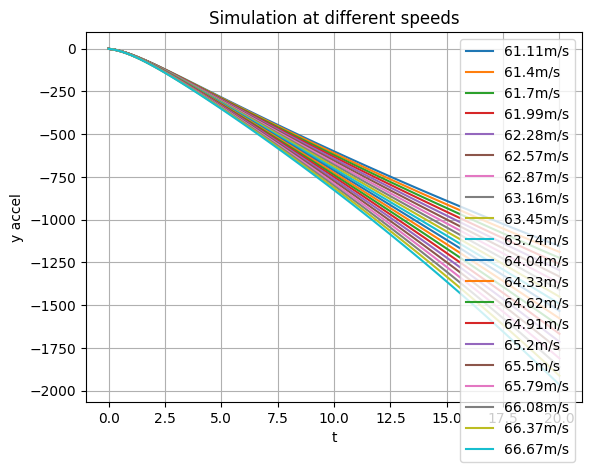

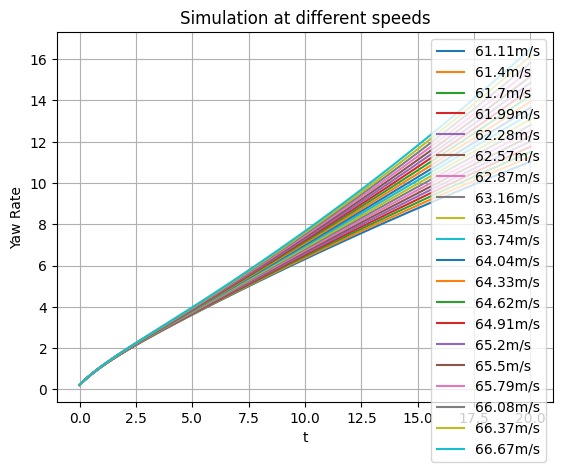

In [16]:
# We want to simulate a range of u values here
u_values_km = np.linspace(220, 240, 20)  # km
u_values = [u * 1000 / 3600 for u in u_values_km]

init_vector = np.array([[0],[0]])
t_final = 20
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

histories = []
labels = []

for u in u_values:
    solver = BicycleSolver(
        m = 1400,
        a = 1.14,
        b = 1.33,
        C_alpha_f = 25000,
        C_alpha_r = 21000,
        I_z = 2420,
        u = u
    )

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)

    histories.append(hist)
    labels.append(f'{str(round(u,2))}m/s')

solver.visualize_results(histories, labels, init_t, t_final, max_iter, title="Simulation at different speeds")

In [17]:
### Task B2
# We can check stability by checking that graph asymptotes instead of diverging,
# i.e. difference between subsequent time steps decreases
for i, history in enumerate(histories):
    y_difference = [history[i][0] - history[i-1][0] for i in range(1, len(history))]
    yaw_difference = [history[i][1] - history[i-1][1] for i in range(1, len(history))]

    if (abs(y_difference[-1]) > abs(y_difference[-5]) or
        abs(yaw_difference[-1]) > abs(yaw_difference[-5])):
        print(f'{u_values_km[i]} diverges')

        if i > 0:
            print(f'{u_values_km[i-1]} converges')
        break

### Task B2 V2
for i, history in enumerate(histories):
    u_yaccel = [history[i][0] / history[i-1][0] for i in range (1, len(history))]
    u_yaw = [history[i][1] / history[i-1][1] for i in range (1, len(history))]

    if (abs(u_yaccel[i]) > 1 or 
        abs(u_yaw[i]) > 1): 
        print(f'{u_values_km[i]} diverges')

        if i > 0:
            print(f'{u_values_km[i-1]} converges')
        break


228.42105263157896 diverges
227.3684210526316 converges
220.0 diverges


Looks like its at ~227.3km/h divergence happens

### Task C: What if you have something in the trunk

Something heavy in the trunk / hood means:
- Total mass changes
- CoG changes, so a & b distances also change

In [18]:
# Placement loc (0) for rear wheel, (1) for front
def get_new_m_a_b(m, a, b, added_w, placement_loc):
    new_m = m + added_w

    # car could be split into 2 point masses at
    # front & rear tires. So the new CoG is just the weighted
    # avg of the new rear & front weights
    front_mass = m / 2 + added_w * placement_loc
    rear_mass = m / 2 + added_w * 1 - placement_loc

    # Fix the coords system @ b = 0
    total = a + b
    frac = rear_mass / new_m
    new_b = total * frac
    new_a = total - new_b

    return new_m, new_a, new_b

In [19]:
# Try putting 10kg on the back wheel of a 10kg car
get_new_m_a_b(10, 1, 1, 10, 0)

(20, 0.5, 1.5)

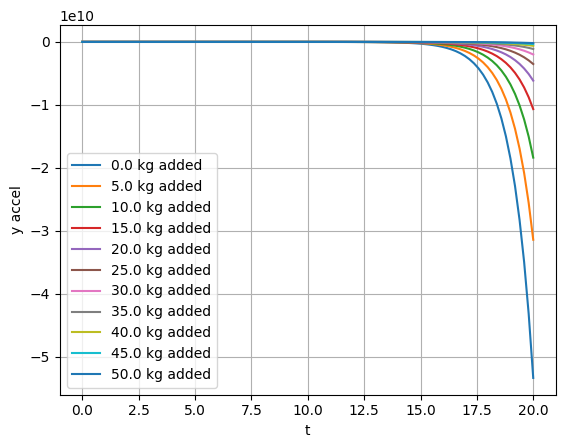

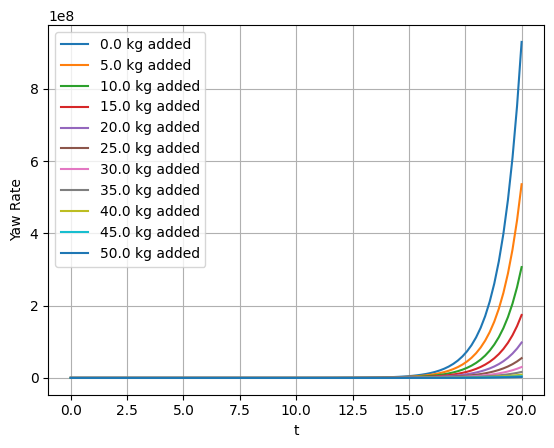

In [20]:
added_w = np.linspace(0, 50, 11)
cog_values = [get_new_m_a_b(1400, 1.14, 1.33, w, 0) for w in added_w]

u = 300 * 1000 / 3600
init_vector = np.array([[0],[0]])
t_final = 20
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

histories = []
labels = []

for i, (m, a, b) in enumerate(cog_values):
    solver = BicycleSolver(
        m = m,
        a = a,
        b = b,
        C_alpha_f = 25000,
        C_alpha_r = 21000,
        I_z = 2420,
        u = u
    )

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)

    histories.append(hist)
    labels.append(f'{round(added_w[i],2)} kg added')

solver.visualize_results(histories, labels, init_t, t_final, max_iter)

C2. Use simulations to show why it is dangerous to drive fast and/or steering hard when there
is snow or ice on the road? Please give several pairs of maneuver conditions (speed and
steering angle) that allow the car to be barely controllable, meaning that if you steer harder
and/or drive faster your car will lose control.



In [21]:
### Task C2

init_vector = np.array([[0],[0]])
t_final = 20
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

#iterate through delta
delta = [0.05, 0.1, 0.15, 0.2, 0.25]

# Convert speed from km/h to m/s
u_values_km = np.linspace(25, 200, 25)  # km/h
u_values = [u * 1000 / 3600 for u in u_values_km]  # m/s


histories = []
labels = []

# Simulate car behavior for different steering angles
for i, u_values in enumerate(delta):
    solver = BicycleSolver(
        m=1400, 
        a=1.14,  
        b=1.33,  
        C_alpha_f=25000,  
        C_alpha_r=21000,  
        I_z = 2420,
        u=u_values  
    )

    res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)

    histories.append(hist)
    labels.append(f'{round(u_values[i],2)} m/s') 

solver.visualize_results(histories, labels, init_t, t_final, max_iter)



C:\Users\carme\AppData\Local\Temp\ipykernel_32248\498555534.py:61: RuntimeWarning: overflow encountered in matmul
  return np.matmul(A, y) + B*delta
C:\Users\carme\AppData\Local\Temp\ipykernel_32248\498555534.py:57: RuntimeWarning: invalid value encountered in add
  return y_curr + step_size / 6 * (k1 + 2*k2 + 2*k3 + k4)


TypeError: 'float' object is not subscriptable

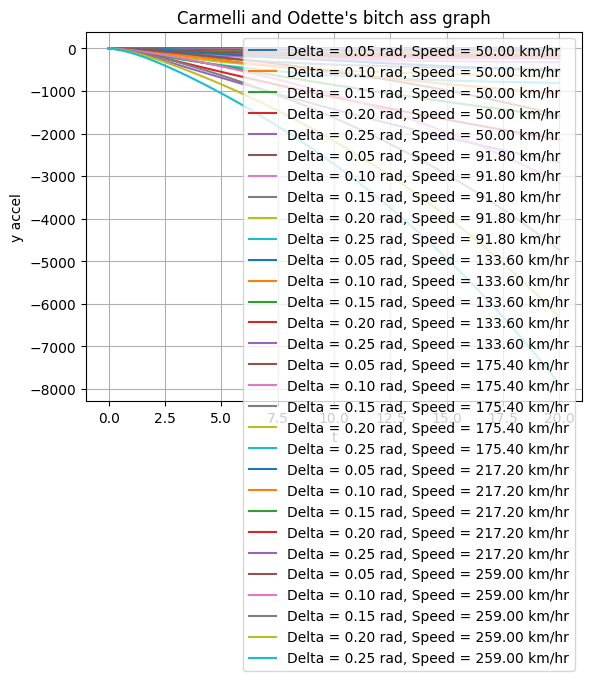

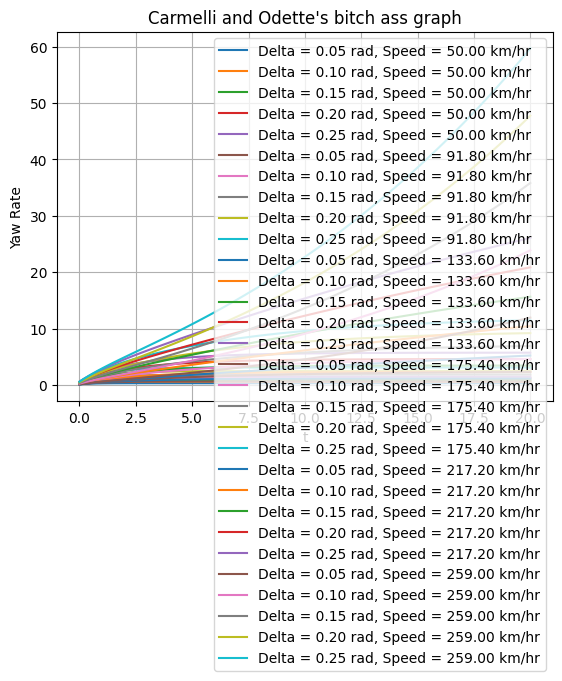

In [45]:
### Task C2 Carmelli

# Convert speed from km/h to m/s
u_values_km = np.linspace(50, 259, 6)  # km/h
u_values = [u * 1000 / 3600 for u in u_values_km]  # m/s

init_vector = np.array([[0],[0]])
t_final = 20
init_t = 0
step_size = 0.2
max_iter = int(t_final / step_size)

#iterate through delta
delta = [0.05, 0.1, 0.15, 0.2, 0.25]


histories = []
labels = []

# Simulate car behavior for different steering angles
for u in u_values:
    for delta_value in delta:
        solver = BicycleSolver(
            m=1400, 
            a=1.14,  
            b=1.33,  
            C_alpha_f=25000,  
            C_alpha_r=21000,  
            I_z = 2420,
            u=u  
        )

        def task_a_model(y,t) -> np.ndarray:
            return solver.bicycle_model(solver.A, solver.B, y, delta_value)

        res, hist = solver.solve(solver.rk4, task_a_model, init_vector, init_t, max_iter, step_size)
    

        histories.append(hist)
        labels.append(f'Delta = {delta_value:.2f} rad, Speed = {u * 3600 / 1000:.2f} km/hr')


solver.visualize_results(histories, labels, init_t, t_final, max_iter, title="Carmelli and Odette's bitch ass graph")



C3. Use your simulations to study and comment on if using winter tires in winter is a good idea.
Hints: (a) When the road is slippery, the friction on the tire cannot exceed a maximum value.
The cornering stiffness is no longer a constant. Instead, we can use a piecewise function to
roughly model 3 the tire performance on icy roads.

In [ ]:
###C3

#piecewise condition to model icy road 
def icy_conditions(delta):
    if delta <= 0.06:
        return 20000
    elif 0.06 < delta <= 0.2:
        return 100
    else:
        return 0
    

        C_alpha_f = icy_conditions(delta),
        C_alpha_r = icy_conditions(delta),